# **Time series forecasting of CO<sub>2</sub> emissions**

by Francesco Parisio (francesco.parisio@protonmail.com)

January 17th, 2022 

## **Introduction**



### **Context**

In order to devise proper policies and actions, we need a basic understanding of the main contributors to CO$_2$ emissions and how emissions evolve with time. The capability to forecast emissions of CO$_2$ is relevant in order to build future climate scenarios; containing the global temperature rise within 2$^{\circ}$C means that each individual country will have to adjust its climate policy and measure the success of the action based on future trend comparison with the available forecasts. Better forecasts mean a higher efficacy of climate policies, better targeted policies and more effective public interventions.


### **Objective**

Accurate forecasts are used to make policy decisions and to measure their efficacy by comparing forecasts with future records. Forecasts accuracy is fundamental for climate policy: the goal of this project is to build a forecasting methodology based on available data.

### **Problem Formulation**:

The project analyses data about CO$_2$ emissions for electricity production in the U.S. from 1973 to 2016. The objectives are further split into sub-categories as. The first part introduces basic data analysis and visualization to get a first understanding of the problem. Then, it explores different methodologies to forecast CO$_2$ emissions from natural gas for the next 12 months period. A Monte Carlo-based cross validation is carried out to make a probabilistic assessment of the forecast reliability. Finally, the optimized model is used to generate a 1 year forecast of CO$_2$ emissions from the electric energy sector in the U.S.

### **Attributes Information:**

This datset is the past monthly data of Carbon dioxide emissions from electricity generation from the US Energy Information Administration categorized by fuel type such as Coal, Natural gas etc. The original data is available from:
https://www.eia.gov/totalenergy/data/browser/index.php?tbl=T11.06#/?f=M&start=200001

**MSN:-** Reference to Mnemonic Series Names (U.S. Energy Information Administration Nomenclature)

**YYYYMM:-** The month of the year on which these emissions were observed

**Value:-** Amount of CO2 Emissions in Million Metric Tons of Carbon Dioxide

**Description:-**  Different category of electricity production through which carbon is emissioned.

## **Loading the libraries**

In [ ]:
# It is recommended to upgrade the statsmodels library. 
# Uncomment the below code to upgrade statsmodels
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 23.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
#Import basic libraries
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## **Loading the data**

In [10]:
InputFilePath = 'MER_T12_06.csv'
df = pd.read_csv(InputFilePath)
df.head()

,MSN,YYYYMM,Value,Description
0,CLEIEUS,197301,72.076,Coal Electric Power Sector CO2 Emissions
1,CLEIEUS,197302,64.442,Coal Electric Power Sector CO2 Emissions
2,CLEIEUS,197303,64.084,Coal Electric Power Sector CO2 Emissions
3,CLEIEUS,197304,60.842,Coal Electric Power Sector CO2 Emissions
4,CLEIEUS,197305,61.798,Coal Electric Power Sector CO2 Emissions


In [11]:
#to ignore warnings
import warnings
import itertools
warnings.filterwarnings("ignore")

In [12]:
#conversion of "YYYYMM" columnn into standard datetime format & making it as index
# We are using errors=’coerce’. It will replace all non-numeric values with NaN.

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_csv(InputFilePath, parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
df['Description'] = df['Description'].str.replace(r' Electric Power Sector CO2 Emissions', '')
df['Description'] = df['Description'].str.replace(r', Including Kerosene-Type Jet Fuel, Oil', '')
df.head(15)

,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal
1973-02-01,CLEIEUS,64.442,Coal
1973-03-01,CLEIEUS,64.084,Coal
1973-04-01,CLEIEUS,60.842,Coal
1973-05-01,CLEIEUS,61.798,Coal
1973-06-01,CLEIEUS,66.538,Coal
1973-07-01,CLEIEUS,72.626,Coal
1973-08-01,CLEIEUS,75.181,Coal
1973-09-01,CLEIEUS,68.397,Coal


**The arguments can be explained as:**

- **parse_dates:** This is a key to identify the date time column. Example, the column name is ‘YYYYMM’.
- **index_col:** This is a key that forces pandas to use the date time column as index.
- **date_parser:** Converts an input string into datetime variable.

- Let us first identify and **drop the non datetimeindex** rows. First, let's convert the index to datetime, coerce errors, and filter NaT

In [13]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts.head()

,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal
1973-02-01,CLEIEUS,64.442,Coal
1973-03-01,CLEIEUS,64.084,Coal
1973-04-01,CLEIEUS,60.842,Coal
1973-05-01,CLEIEUS,61.798,Coal


In [14]:
#Check the datatypes of each column. Hint: Use dtypes method
ts.dtypes

MSN            object
Value          object
Description    object
dtype: object

In [15]:
#convert the emision value into numeric value
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts.head()

,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal
1973-02-01,CLEIEUS,64.442,Coal
1973-03-01,CLEIEUS,64.084,Coal
1973-04-01,CLEIEUS,60.842,Coal
1973-05-01,CLEIEUS,61.798,Coal


In [16]:
ts.dtypes

MSN             object
Value          float64
Description     object
dtype: object

In [17]:
#Check total number of missing values of each column. Hint: Use isnull() method
ts.isnull().sum()

MSN              0
Value          384
Description      0
dtype: int64

In [18]:
#Drop the missing value using dropna(inplace = True)
ts.dropna(inplace = True)
ts.isnull().sum()

MSN            0
Value          0
Description    0
dtype: int64

In [19]:
ts.shape

(4323, 3)

## **Dataset visualization**

- The dataset has 8 energy sources of CO2 emission. 
- Group the CO2 Emission dataset based on the type of energy source.

In [20]:
EnergyType = ts.groupby('Description')
EnergyType.head()

,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal
1973-02-01,CLEIEUS,64.442,Coal
1973-03-01,CLEIEUS,64.084,Coal
1973-04-01,CLEIEUS,60.842,Coal
1973-05-01,CLEIEUS,61.798,Coal
1973-01-01,NNEIEUS,12.175,Natural Gas
1973-02-01,NNEIEUS,11.708,Natural Gas
1973-03-01,NNEIEUS,13.994,Natural Gas
1973-04-01,NNEIEUS,14.627,Natural Gas


#### **Visualize the dependency of the emission in the power generation with time.**

In [21]:
cols = ['Geothermal Energy', 'Non-Biomass Waste', 'Petroleum Coke','Distillate Fuel ',
        'Residual Fuel Oil', 'Petroleum', 'Natural Gas', 'Coal', 'Total Emissions']


In [22]:
for key, grp in EnergyType:
  print(key)
  print(grp['Description'])


Coal
YYYYMM
1973-01-01    Coal
1973-02-01    Coal
1973-03-01    Coal
1973-04-01    Coal
1973-05-01    Coal
              ... 
2016-03-01    Coal
2016-04-01    Coal
2016-05-01    Coal
2016-06-01    Coal
2016-07-01    Coal
Name: Description, Length: 523, dtype: object
Distillate Fuel
YYYYMM
1973-01-01    Distillate Fuel
1973-02-01    Distillate Fuel
1973-03-01    Distillate Fuel
1973-04-01    Distillate Fuel
1973-05-01    Distillate Fuel
                   ...       
2016-03-01    Distillate Fuel
2016-04-01    Distillate Fuel
2016-05-01    Distillate Fuel
2016-06-01    Distillate Fuel
2016-07-01    Distillate Fuel
Name: Description, Length: 523, dtype: object
Geothermal Energy
YYYYMM
1989-01-01    Geothermal Energy
1989-02-01    Geothermal Energy
1989-03-01    Geothermal Energy
1989-04-01    Geothermal Energy
1989-05-01    Geothermal Energy
                    ...        
2016-03-01    Geothermal Energy
2016-04-01    Geothermal Energy
2016-05-01    Geothermal Energy
2016-06-01    Geother

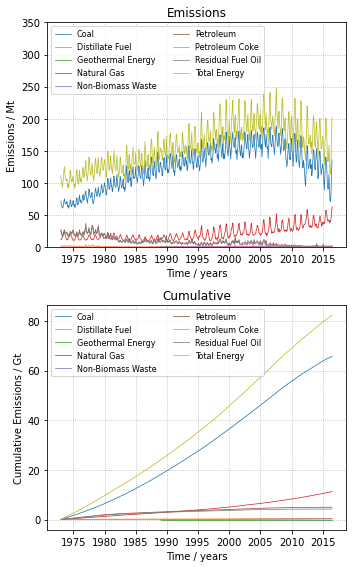

In [23]:
## Code here
fig, ax = plt.subplots(2,1,figsize=(5,8))
for key, grp in EnergyType:
    ax[0].plot(grp.index, grp['Value'], label=key,linewidth=0.75)
    ax[0].set_xlabel('Time / years')
    ax[0].set_ylabel(r'Emissions / Mt')
    ax[0].grid('on',linestyle=':')
    ax[0].set_title('Emissions')
    ax[0].legend(fontsize=8,ncol=2)
    ax[0].set_ylim([0,350])

    ax[1].plot(grp.index, grp['Value'].cumsum()/1e3, label=key,linewidth=0.75)
    ax[1].set_xlabel('Time / years')
    ax[1].set_ylabel(r'Cumulative Emissions / Gt')
    ax[1].grid('on',linestyle=':')
    ax[1].set_title('Cumulative')
    ax[1].legend(fontsize=8,ncol=2)

fig.tight_layout()
fig.savefig("TotalEmissionsTimeGraph.pdf", dpi=500)

**Observations and Insights:**
- Coal power generation has always been the largest CO2 emitters since data are recorded; 
- Emissions from coal amount to almost the total;
- Natural gas is the second emitter;
- Residual oil and petroleum used to be the second emitters until roughly the early 1980s;
- Since roughly 2010, all emissions other than natural gas and coal are practically negligible;
- Total emissions started to decrease after 2005, while a continuous increase had been observed from the 1970s.

#### **Visualize the trend of CO2 emission from each energy source individually**


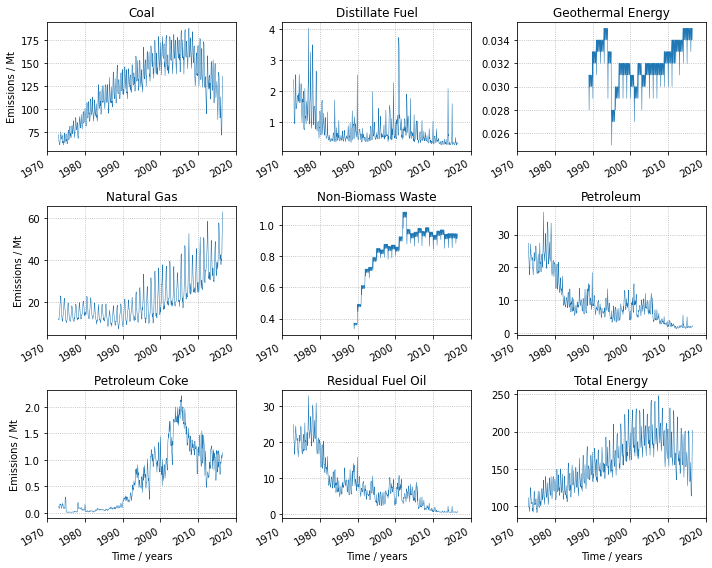

In [24]:
###Code here
fig, axes = plt.subplots(3,3, figsize = (10, 8))
a=np.array([1,0,0])
b=np.array([0,0,0])
c=np.array([1,1,1])
FlagLegendX=np.vstack((b,b,c)).flatten()*(np.arange(len(axes.flatten()))+1)
FlagLegendY=np.vstack((a,a,a)).flatten()*np.arange(len(axes.flatten()))
i=0
for (desc, group), ax in zip(EnergyType, axes.flatten()):
    ax.plot(group.index, group['Value'], label=desc,linewidth=0.5)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=10)) 
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.set_xlim(pd.Timestamp('1970-01-01'), pd.Timestamp('2020-01-01'))
    ax.set_title(desc,fontsize=12)
    if (i+1)==FlagLegendX[i]:
      ax.set_xlabel('Time / years')
    if i==FlagLegendY[i]:
      ax.set_ylabel(r'Emissions / Mt')
    i=i+1
    ax.grid('on',linestyle=':')
    for label in ax.get_xticklabels(which='major'):
      label.set(rotation=30, horizontalalignment='right')

fig.tight_layout()
fig.savefig("EmissionsPerSource.pdf", dpi=500)


#### **Observations and Insights:**
- Coal is the largest emitter, although in decline;
- Emissions from natural gas, the second emitter, keep rising;
- Residual oil, petroleum and distillate fuel emissions decreased in the years and are now small compared to the total emissions; 
- Emissions from geothermal energy are negligible and practically constant (could be removed for database);
- Non-biomass emissions increased in the 1990s and are now a small but constant fraction of the total.


#### **Bar chart of CO2 Emissions per energy source**

In [ ]:
CO2_per_source = ts.groupby('Description')['Value'].sum().sort_values()

In [ ]:
cols = ['Geothermal Energy', 'Non-Biomass Waste', 'Petroleum Coke','Distillate Fuel ',
        'Residual Fuel Oil', 'Petroleum', 'Natural Gas', 'Coal', 'Total Emissions']

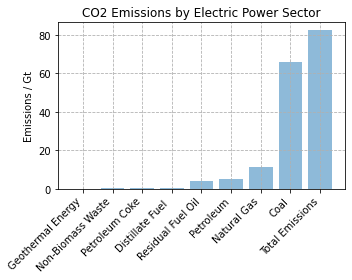

In [ ]:
##Code here
fig, ax = plt.subplots(figsize=(5,4))
x_label = cols
x_tick = np.arange(len(cols))
ax.bar(x_tick, CO2_per_source/1e3, align = 'center', alpha = 0.5)
ax.set_title("CO2 Emissions by Electric Power Sector", fontsize= 12)
ax.set_xticks(x_tick)
ax.set_xticklabels(labels=x_label, rotation = 45, ha='right')
ax.set_ylabel('Emissions / Gt')
ax.grid('on',linestyle='--')
fig.tight_layout()
fig.savefig("EmissionsPerSourceBarPlot.pdf", dpi=500)


#### **For developing the time series model and forcasting, use the natural gas CO2 emission from the electirical power generation**


In [ ]:
TotalEmissions = ts.iloc[:,1:]   # Monthly total emissions (mte)
TotalEmissions = TotalEmissions.groupby(['Description', pd.Grouper(freq="M")])['Value'].sum().unstack(level = 0)
GasEmissions_old = TotalEmissions['Natural Gas'] # monthly total emissions (mte)
GasEmissions_old

YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
               ...  
2016-03-31    40.525
2016-04-30    39.763
2016-05-31    44.210
2016-06-30    53.567
2016-07-31    62.881
Freq: M, Name: Natural Gas, Length: 523, dtype: float64

In [ ]:
GasEmissions = pd.DataFrame(columns=['YYYYMM','Emissions'])
GasEmissions.YYYYMM = TotalEmissions.index
GasEmissions.Emissions = np.asarray(TotalEmissions['Natural Gas'].copy()) 
GasEmissions = GasEmissions.set_index(['YYYYMM'])
GasEmissions.head()

,Emissions
YYYYMM,
1973-01-31,12.175
1973-02-28,11.708
1973-03-31,13.994
1973-04-30,14.627
1973-05-31,17.344


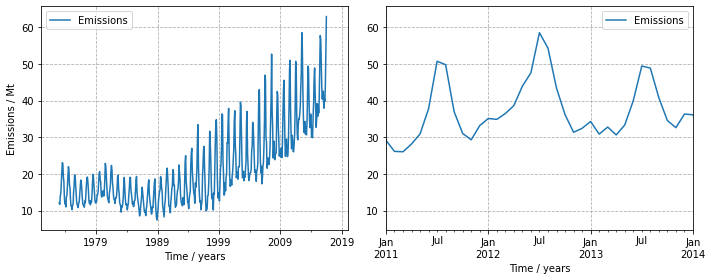

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
#ax.plot(GasEmissions.x, GasEmissions.y)#, label=desc)
GasEmissions.plot(ax=ax[0])
ax[0].set_xlabel('Time / years')
ax[0].set_ylabel(r'Emissions / Mt')
#ax[0].set_title(GasEmissions.name,fontsize=12)
ax[0].grid('on',linestyle='--')
ax[0].set_xlim(pd.Timestamp('1970-01-01'), pd.Timestamp('2020-01-01'))

lower_time='01-01-2011'
upper_time='01-01-2014'
# Alternative solution to plot the zoom, is to clip the data within min-max values of timestamp
#GasEmissionsClipped=(GasEmissions[GasEmissions.index>lower_time].copy())[(GasEmissions[GasEmissions.index>lower_time].copy()).index<upper_time].copy()
#GasEmissionsClipped.plot(ax=ax[1])

GasEmissions.plot(ax=ax[1])
ax[1].set_xlabel('Time / years')
#ax[1].set_title(GasEmissions.name+', zoomed',fontsize=12)
ax[1].grid('on',linestyle='--')
ax[1].set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2014-01-02'))

fig.tight_layout()
fig.savefig("EmissionsGas.pdf", dpi=500)


#### **Observations & insights:**
- Emissions from natural gas witnessed a sharp increase since the early 1990s;
- Emissions from natural gas show an oscillatory behavior that is likely related to the seasonality of energy demand;
- From a zoom-in in the time series of natural gas emissions from 2011 to 2014, it can be better observed the seasonality of the emissions;
- Emissions are higher in the summer months, most likely because electricity consumption increases in the summer as a consequence of the air conditioning needs. 

## **Natural gas based CO2 emission forecasting**

For developing the time series model and forecasting, you are expected to use the natural gas CO2 emission from the electrical power generation. We need to slice this data:

In [ ]:
#Check 1st few rows of data
GasEmissions.head()

,Emissions
YYYYMM,
1973-01-31,12.175
1973-02-28,11.708
1973-03-31,13.994
1973-04-30,14.627
1973-05-31,17.344


## **Split the dataset**

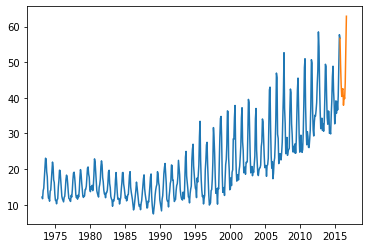

In [ ]:
# Split the data into train and test
GasEmissionsTrain = GasEmissions.loc[:'2015-08-31']
GasEmissionsTest = GasEmissions.loc['2015-08-31' : ]
plt.plot(GasEmissionsTrain)
plt.plot(GasEmissionsTest)

## **Stationarity tests**

In [ ]:
#Import the required package
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [ ]:
# Common formatting plot for time series
def FormattingTimePlot(ax_):
  ax_.grid('on',linestyle=':')
  ax_.legend()
  ax_.set_xlim(pd.Timestamp('1973-01-31'), pd.Timestamp('2015-08-31'))
  ax_.xaxis.set_major_locator(mdates.YearLocator(base=10)) 
  ax_.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax_.xaxis.get_major_locator()))
  for label in ax_.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
  return 0


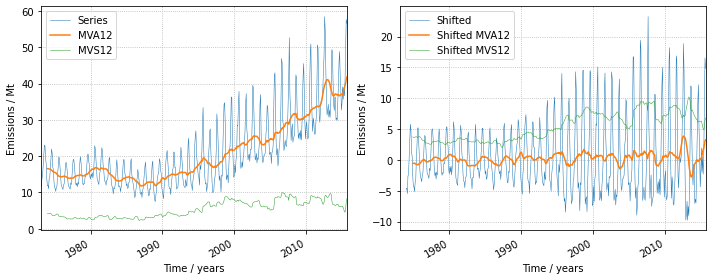

In [ ]:
# Calculate the rolling mean and standard deviation for a window of 12 observations
MVA12 = GasEmissionsTrain.rolling(12).mean()
MVS12 = GasEmissionsTrain.rolling(12).std()

# Subtract MVA12 to series to make it stationary
GasEmissionsTrain_D_MVA12 = GasEmissionsTrain - MVA12 
GasEmissionsTrain_D_MVA12.dropna(inplace = True)

# Build rolling mean and std of subtracted series
MVA12D = GasEmissionsTrain_D_MVA12.rolling(12).mean()
MVS12D = GasEmissionsTrain_D_MVA12.rolling(12).std()

# Visualize the rolling mean and standard deviation
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(GasEmissionsTrain,label='Series',linewidth=0.5)
ax[0].plot(MVA12,label='MVA12')
ax[0].plot(MVS12,label='MVS12',linewidth=0.5)
ax[0].set_xlabel('Time / years')
ax[0].set_ylabel(r'Emissions / Mt')
FormattingTimePlot(ax[0])

ax[1].plot(GasEmissionsTrain_D_MVA12,label='Shifted',linewidth=0.5)
ax[1].plot(MVA12D,label='Shifted MVA12')
ax[1].plot(MVS12D,label='Shifted MVS12',linewidth=0.5)
ax[1].set_xlabel('Time / years')
ax[1].set_ylabel(r'Emissions / Mt')
FormattingTimePlot(ax[1])

fig.tight_layout()

**Observations:**
- The plot shows an increase of the moving average with time, which disappears if the rolling mean is applied to the series shifted by the 12-months rolling average. The plot hints at the fact that the series is non-stationary.
- Applying a shift of MVA12 to the origina series shows a rolling mean that is approximately zero;

### **Test the stationarity using the Augmented Dickey-Fuller Test**


The **Augmented Dickey-Fuller (ADF) Test** is used to verify if the series is stationary or not. The null and alternate hypotheses for the ADF Test are defined as:

**- Null hypothesis:** The Time Series is non-stationary


**- Alternative hypothesis:** The Time Series is stationary

In [ ]:
#Define a function to use adfuller test
def TestADF(InputData, CriticalPValue = 0.05):
    ADFTest = adfuller(InputData, autolag = 'AIC')
    ADFTestOutput = pd.Series(ADFTest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
    
    # Print output ADF test
    print(ADFTestOutput)

    print('#'*25)
    # Test for stationariy
    if ADFTest[1] <= CriticalPValue:
        print('p-value = '+str(ADFTest[1])+' <= ' + str(CriticalPValue) + '; the series is stationary')
    else:
        print('p-value = '+str(ADFTest[1])+' > ' + str(CriticalPValue) + '; the series is non-stationary')

In [ ]:
TestADF(GasEmissionsTrain['Emissions'])

Test Statistic           1.448785
p-value                  0.997325
Lags Used               19.000000
No. of Observations    492.000000
dtype: float64
#########################
p-value = 0.9973248753503299 > 0.05; the series is non-stationary


In [ ]:
TestADF(GasEmissionsTrain_D_MVA12['Emissions'])

Test Statistic        -6.914168e+00
p-value                1.191210e-09
Lags Used              1.400000e+01
No. of Observations    4.860000e+02
dtype: float64
#########################
p-value = 1.191209573905701e-09 <= 0.05; the series is stationary


**Observations:**
- The ADF test confirms that the series is non-stationary, while it becomes stationary if the 12-months rolling average is removed from the series;
- The ADF test on the MVA12 shifted series stationarity confirms the indications of the visual plot; 

### **Transformation of the dataset into a stationary one**

**We can use some of the following methods to convert a non-stationary series into a stationary one:**


1. Log Transformation
2. Differencing the series (lagged series)

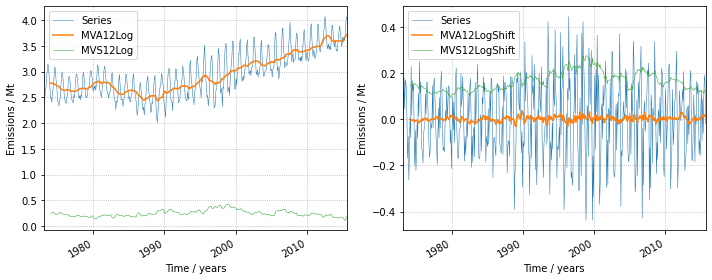

In [ ]:
 # Visualize the rolling mean and standard deviation after using log transformation
GasEmissionsTrainLog = np.log(GasEmissionsTrain)
MVA12Log = GasEmissionsTrainLog.rolling(window=12).mean()
MVS12Log = GasEmissionsTrainLog.rolling(window=12).std()

# Apply shift
GasEmissionsTrainShift = GasEmissionsTrainLog - GasEmissionsTrainLog.shift(periods = 1)
GasEmissionsTrainShift.dropna(inplace = True)
MVA12Shift = GasEmissionsTrainShift.rolling(window=12).mean()
MVS12Shift =  GasEmissionsTrainShift.rolling(window=12).std()

# Visualize the rolling mean and standard deviation
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(GasEmissionsTrainLog,label='Series',linewidth=0.5)
ax[0].plot(MVA12Log,label='MVA12Log')
ax[0].plot(MVS12Log,label='MVS12Log',linewidth=0.5)
ax[0].set_xlabel('Time / years')
ax[0].set_ylabel(r'Emissions / Mt')
FormattingTimePlot(ax[0])

ax[1].plot(GasEmissionsTrainShift,label='Series',linewidth=0.5)
ax[1].plot(MVA12Shift,label='MVA12LogShift')
ax[1].plot(MVS12Shift,label='MVS12LogShift',linewidth=0.5)
ax[1].set_xlabel('Time / years')
ax[1].set_ylabel(r'Emissions / Mt')
FormattingTimePlot(ax[1])

fig.tight_layout()

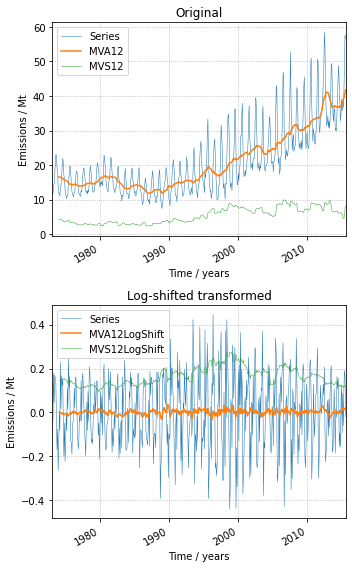

In [ ]:
# Plot only original and logshifted series for final report
fig, ax = plt.subplots(2,1, figsize=(5,8))

ax[0].plot(GasEmissionsTrain,label='Series',linewidth=0.5)
ax[0].plot(MVA12,label='MVA12')
ax[0].plot(MVS12,label='MVS12',linewidth=0.5)
ax[0].set_xlabel('Time / years')
ax[0].set_ylabel(r'Emissions / Mt')
ax[0].set_title(r'Original')
FormattingTimePlot(ax[0])

ax[1].plot(GasEmissionsTrainShift,label='Series',linewidth=0.5)
ax[1].plot(MVA12Shift,label='MVA12LogShift')
ax[1].plot(MVS12Shift,label='MVS12LogShift',linewidth=0.5)
ax[1].set_xlabel('Time / years')
ax[1].set_ylabel(r'Emissions / Mt')
ax[1].set_title(r'Log-shifted transformed')
FormattingTimePlot(ax[1])

fig.tight_layout()

We can define a function that tranforms the series by applying a log and a shift-1 transformation. Accordingly, we can define a reverse transformation function.

In [ ]:
def LogShiftTransform(Series):
  TransformedLogShiftSeries = np.log(Series) - np.log(Series).shift(periods = 1)
  TransformedLogShiftSeries.dropna(inplace = True) 
  return TransformedLogShiftSeries

def InvertLogShift(SeriesLog,SeriesLogShift):
  x, x_diff = SeriesLog['Emissions'].iloc[0], SeriesLogShift['Emissions'].iloc[1:]
  Unshifted = np.exp(np.r_[x, x_diff].cumsum())
  NewSeries = SeriesLogShift.copy()
  NewSeries.Emissions = Unshifted
  return NewSeries

We can test the functions

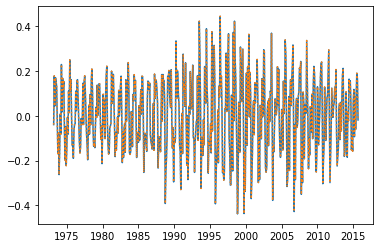

In [ ]:
# Validation of Inversion function
plt.plot(GasEmissionsTrainShift)
plt.plot(LogShiftTransform(GasEmissionsTrain),':')

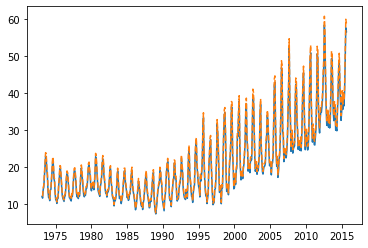

In [ ]:
# Validation of Inversion function
plt.plot(GasEmissionsTrain)
plt.plot(InvertLogShift(GasEmissionsTrainLog,GasEmissionsTrainShift),'--')

**Observations:**
- The tranform and the inverse are validated.

We can apply the ADF test to the log transformation and to the log and shift transformed series

In [ ]:
TestADF(GasEmissionsTrainLog['Emissions'])

Test Statistic           0.437321
p-value                  0.982838
Lags Used               19.000000
No. of Observations    492.000000
dtype: float64
#########################
p-value = 0.9828382220533769 > 0.05; the series is non-stationary


In [ ]:
TestADF(GasEmissionsTrainShift['Emissions'])

Test Statistic          -4.878315
p-value                  0.000038
Lags Used               18.000000
No. of Observations    492.000000
dtype: float64
#########################
p-value = 3.842709105650547e-05 <= 0.05; the series is stationary


**Observations and Insights:**
- Both the visual plot and ADF test show that taking the log transformation does not make the series stationary;
- On the contrary, log and shift of 1 the series makes is stationary;

## **Elimination of trend and seasonality: Decomposition**

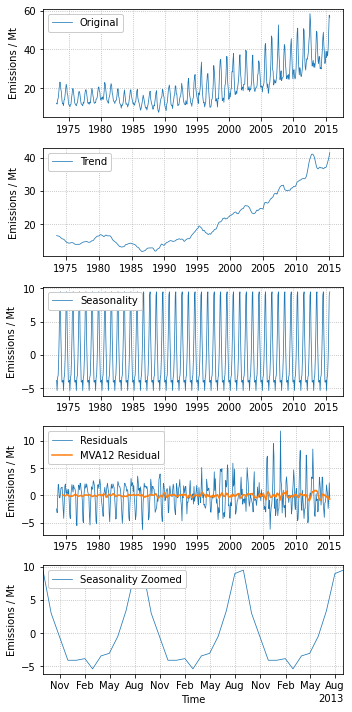

In [ ]:
#Importing the seasonal_decompose function to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(GasEmissionsTrain)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid
MVA12Residual = residual.rolling(window=12).mean()

# You can follow the previous case study/projects notebook to plot it
# Visualize the rolling mean and standard deviation
fig, ax = plt.subplots(5,1, figsize=(5,10))

Series2Plot = [GasEmissionsTrain, trend, seasonal, residual, seasonal]
SeriesNames = ['Original','Trend','Seasonality','Residuals','Seasonality Zoomed']
for i in range(len(Series2Plot)):
  ax[i].plot(Series2Plot[i],label=SeriesNames[i],linewidth=0.75)
  if SeriesNames[i]=='Residuals':
    ax[i].plot(MVA12Residual,label='MVA12 Residual')
  if i==len(Series2Plot)-1:
    ax[i].set_xlabel('Time')
    ax[i].set_xlim(pd.Timestamp('2010-08-31'), pd.Timestamp('2013-08-31'))
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
    ax[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[i].xaxis.get_major_locator()))

  ax[i].set_ylabel(r'Emissions / Mt')
  ax[i].grid('on',linestyle=':')
  ax[i].legend(framealpha=1)

fig.tight_layout()

**Observations and Insights:**
- The trend shows a constant increase since approx. 1990;
- Seasonality shows an increment in emissions in the summer months;
- The MVA12 of the residuals is always approximately 0, meaning that removing trend and seasonality to the series would make it stationary;

## **Find optimal parameters (P, Q) and build the AR, MA, ARMA & ARIMA models**

To get p and q values for AR, MA, ARMA, and ARIMA models, we will plot the auto-correlation function and partial auto-correlation function. ACF and PACF charts are used to find the optimal parameters

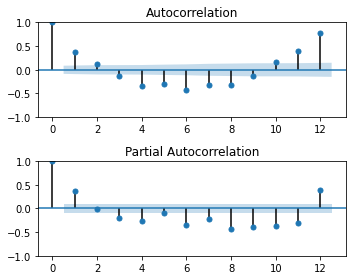

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, ax = plt.subplots(2,1, figsize=(5,4))
xx_ = plot_acf(GasEmissionsTrainShift, lags = 12,ax=ax[0]) 
yy_ = plot_pacf(GasEmissionsTrainShift, lags = 12,ax=ax[1]) 

fig.tight_layout()

**Observations and Insights:**
- PCF shows that after lag=1, it becomes statistically insignificant, but then increases again;
- For the AR component, we will assume lag=1 (p=1);
- It's notheworthy to see the spike at p=12, which is likely indicating the seasonality component of the emissions which occurs at a frequency of 12 months (yearly);

### **Build the AR, MA, ARMA & ARIMA models**

Here, we will build AR, MA, ARMA and ARIMA models with p=1 on the log-shifted series. We will evaluate performance on past data (training) as well as on 12 months forecast (testing). Performance will be measured through RMSE and AIC score.

In [ ]:
# Import the proper libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

#### **AR Model**

In [ ]:
#Code here
model_AR =  AutoReg(GasEmissionsTrainShift, lags=1) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
predict_AR = results_AR.predict(start=0,end=len(GasEmissionsTrainShift)-1) #predict the series 
predict_AR = predict_AR.fillna(0) #Converting NaN values to 0
PredictionSeries_AR = GasEmissionsTrainShift.copy()
PredictionSeries_AR.Emissions = predict_AR
PredictionsTransformed_AR = InvertLogShift(GasEmissionsTrainLog,PredictionSeries_AR)
RMSE_AR = mean_squared_error(PredictionsTransformed_AR,GasEmissionsTrain[1:], squared=False)
AIC_AR = results_AR.aic

#### **MA Model**

In [ ]:
#Code here
model_MA =  ARIMA(GasEmissionsTrainShift, order=(0, 0, 1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit() #fit the model
predict_MA = results_MA.predict(start=0,end=len(GasEmissionsTrainShift)-1) #predict the series 
predict_MA = predict_MA.fillna(0) #Converting NaN values to 0
PredictionSeries_MA = GasEmissionsTrainShift.copy()
PredictionSeries_MA.Emissions = predict_MA
PredictionsTransformed_MA = InvertLogShift(GasEmissionsTrainLog,PredictionSeries_MA)
RMSE_MA = mean_squared_error(PredictionsTransformed_MA,GasEmissionsTrain[1:], squared=False)
AIC_MA = results_MA.aic

#### **ARMA MODEL**

In [ ]:
#Code here
model_ARMA =  ARIMA(GasEmissionsTrainShift, order=(1, 0, 1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_ARMA.fit() #fit the model
predict_ARMA = results_ARMA.predict(start=0,end=len(GasEmissionsTrainShift)-1) #predict the series 
predict_ARMA = predict_ARMA.fillna(0) #Converting NaN values to 0
PredictionSeries_ARMA = GasEmissionsTrainShift.copy()
PredictionSeries_ARMA.Emissions = predict_ARMA
PredictionsTransformed_ARMA = InvertLogShift(GasEmissionsTrainLog,PredictionSeries_ARMA)
RMSE_ARMA = mean_squared_error(PredictionsTransformed_ARMA,GasEmissionsTrain[1:], squared=False)
AIC_ARMA = results_ARMA.aic

#### **ARIMA MODEL**

In [ ]:
#Code here
model_ARIMA =  ARIMA(GasEmissionsTrainShift, order=(1, 1, 1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_ARIMA = model_ARIMA.fit() #fit the model
predict_ARIMA = results_ARIMA.predict(start=0,end=len(GasEmissionsTrainShift)-1) #predict the series 
predict_ARIMA = predict_ARIMA.fillna(0) #Converting NaN values to 0
PredictionSeries_ARIMA = GasEmissionsTrainShift.copy()
PredictionSeries_ARIMA.Emissions = predict_ARIMA
PredictionsTransformed_ARIMA = InvertLogShift(GasEmissionsTrainLog,PredictionSeries_ARIMA)
RMSE_ARIMA = mean_squared_error(PredictionsTransformed_ARIMA,GasEmissionsTrain[1:], squared=False)
AIC_ARIMA = results_ARIMA.aic

### **Plotting comparison of AR, MA, ARMA and ARIMA**

Here we compare the 4 different models by evaluating RMSE on the historical data (training) and by comparing AIC. 

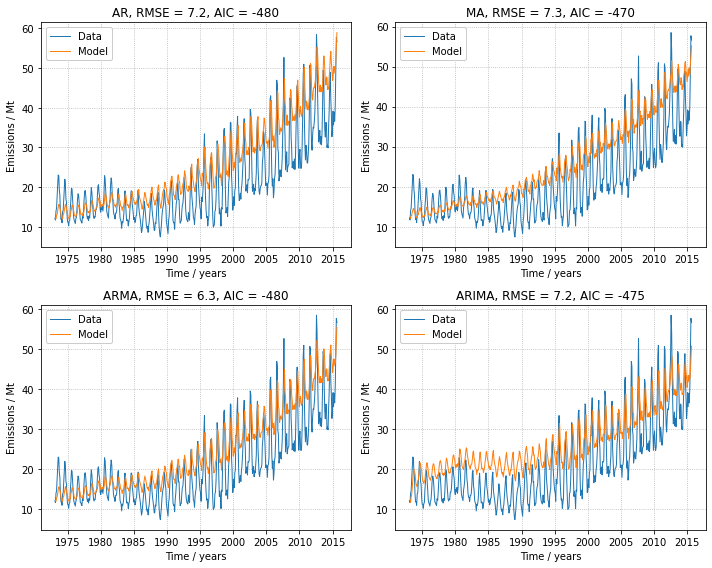

In [ ]:
# Plotting all models for comparison
# Visualize the rolling mean and standard deviation
fig, ax = plt.subplots(2,2, figsize=(10,8))

ax[0,0].plot(GasEmissionsTrain,label='Data',linewidth=1.0)
ax[0,0].plot(PredictionsTransformed_AR,label='Model',linewidth=1.0)
ax[0,0].set_title('AR, RMSE = %.1f, AIC = %.0f'%(RMSE_AR, AIC_AR))

ax[0,1].plot(GasEmissionsTrain,label='Data',linewidth=1.0)
ax[0,1].plot(PredictionsTransformed_MA,label='Model',linewidth=1.0)
ax[0,1].set_title('MA, RMSE = %.1f, AIC = %.0f'%(RMSE_MA, AIC_MA))

ax[1,0].plot(GasEmissionsTrain,label='Data',linewidth=1.0)
ax[1,0].plot(PredictionsTransformed_ARMA,label='Model',linewidth=1.0)
ax[1,0].set_title('ARMA, RMSE = %.1f, AIC = %.0f'%(RMSE_ARMA, AIC_ARMA))

ax[1,1].plot(GasEmissionsTrain,label='Data',linewidth=1.0)
ax[1,1].plot(PredictionsTransformed_ARIMA,label='Model',linewidth=1.0)
ax[1,1].set_title('ARIMA, RMSE = %.1f, AIC = %.0f'%(RMSE_ARIMA, AIC_ARIMA))

for i in range(2):
  for j in range(2):
    ax[i,j].set_xlabel('Time / years')
    #ax[i,j].set_xlim(pd.Timestamp('2008-08-31'), pd.Timestamp('2013-08-31'))
    ax[i,j].set_ylabel(r'Emissions / Mt')
    ax[i,j].grid('on',linestyle=':')
    ax[i,j].legend(framealpha=1)

fig.tight_layout()

**Observations & Insights:**
- The ranking (best to worst) in terms of RMSE is: 1) ARIMA; 2) ARMA; 3) MA; 4) AR.
- The ranking (best to worst) in terms of AIC is: 1) AR; 2) ARMA; 3) ARIMA; 4) MA.
- Based on both ranking, the MA and AR models can be discarded as they are either more complex or less performant on training data.


### **Compare AR, MA, ARMA and ARIMA in the testing dataset**

To compare the performance on forecast on unseen data (testing), we can use the Symmetric Mean Absolute Percentage Error (SMAPE). It is a customary measure in time series 

In [ ]:
# Defining SMAPE function
def CalculateSMAPE(Y_actual,Y_Predicted):
    smape = np.mean(np.abs(Y_Predicted - Y_actual) / ((np.abs(Y_Predicted) + np.abs(Y_actual))/2))*100
    return smape

Apply transformations to the test dataset

In [ ]:
GasEmissionsTestLog = np.log(GasEmissionsTest)
GasEmissionsTestShift = LogShiftTransform(GasEmissionsTest)

Define a function to plot the forecasted values of the different models

In [ ]:
def PlotForecast(model,ax,model_name):
  Forecast = model.predict(start=str(np.min(GasEmissionsTest.index)),end=str(np.max(GasEmissionsTest.index))) #predict the series 
  ForecastSeries = GasEmissionsTestShift.copy()
  ForecastSeries.Emissions = Forecast
  ForecastTransformed = InvertLogShift(GasEmissionsTestLog,ForecastSeries)
  RMSE_Test = mean_squared_error(ForecastTransformed,GasEmissionsTest[1:], squared=False)
  SMAPE = CalculateSMAPE(np.asarray(ForecastTransformed.values),np.asarray(GasEmissionsTest['Emissions'].values))
  ax.plot(GasEmissionsTest,label='Data')
  ax.plot(ForecastTransformed,label='Forecast')
  ax.set_title(model_name+', RMSE = %.2f, SMAPE = %.2f'%(RMSE_Test, SMAPE))


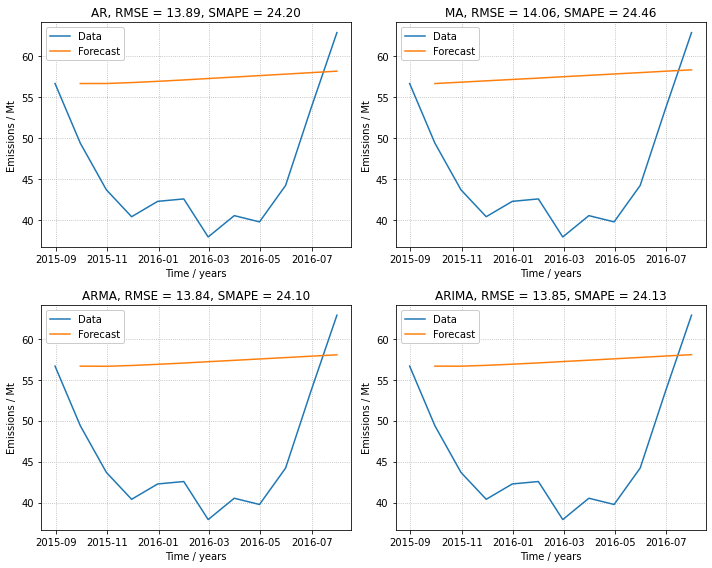

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

PlotForecast(results_AR,ax[0,0],'AR')
PlotForecast(results_MA,ax[0,1],'MA')
PlotForecast(results_ARMA,ax[1,0],'ARMA')
PlotForecast(results_ARIMA,ax[1,1],'ARIMA')

for i in range(2):
  for j in range(2):
    ax[i,j].set_xlabel('Time / years')
    #ax[i,j].set_xlim(pd.Timestamp('2008-08-31'), pd.Timestamp('2013-08-31'))
    ax[i,j].set_ylabel(r'Emissions / Mt')
    ax[i,j].grid('on',linestyle=':')
    ax[i,j].legend(framealpha=1)

fig.tight_layout()

**Observations & Insights:**
- All models perform very poorly on forecasts, likely because seasonality is 12 periods and it's missed by all modells. 
- To overcome the problem, we will optimize ARIMA and train another model based on SARIMAX.

Testing ARIMA with p=12 if performances are improved in validation.

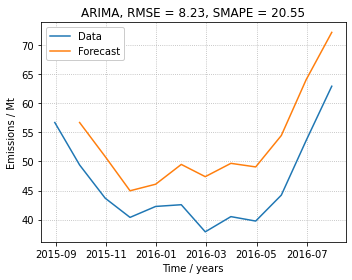

In [ ]:
model_ARIMA_p12 =  ARIMA(GasEmissionsTrainShift, order=(12, 1, 1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_ARIMA_p12 = model_ARIMA_p12.fit() #fit the model

fig, ax = plt.subplots(1,1, figsize=(5,4))

PlotForecast(results_ARIMA_p12,ax,'ARIMA')
ax.set_xlabel('Time / years')
ax.set_ylabel(r'Emissions / Mt')
ax.grid('on',linestyle=':')
ax.legend(framealpha=1)

fig.tight_layout()

**Observations:**
- Performance has increased, but SMAPE remains above 20%;
- We shall proceed to grid-search optimization of ARIMA model parameters;

## **Optimize the ARIMA model**

In [ ]:
# Function to compute RMSE
def RMSEArima(p,d,q,DataSetTrain,DataSetTest):
  model =  ARIMA(DataSetTrain, order=(p, d, q)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
  results = model.fit() #fit the model
  pred = results.get_prediction(start = str(np.min(DataSetTest.index)), end = str(np.max(DataSetTest.index)), dynamic=False)
  RMSETrain = mean_squared_error(results.fittedvalues,DataSetTrain, squared=False)
  RMSETest = mean_squared_error(pred.predicted_mean,DataSetTest, squared=False)
  return RMSETrain, RMSETest

Grid-search function for the ARIMA parameters. The best model is evaluated from the RMSE in the forecast (test dataset).

In [ ]:
# Grid search for arima
'''
p_param = [1,2,4,12]
d_param = [1,2,3,4]
q_param = [1,2,3,4]
rmse_tra = []
rmse_tst = []
pp = []
dd = []
qq = []
for i in range(len(p_param)):
  for j in range(len(d_param)):
    for k in range(len(q_param)):
      RMSE1,RMSE2 = RMSEArima(p_param[i],d_param[j],q_param[k],GasEmissionsTrain,GasEmissionsTest) # RMSE for test and train
      rmse_tra.append(RMSE1)
      rmse_tst.append(RMSE2)
      pp.append(p_param[i])
      dd.append(d_param[j])
      qq.append(q_param[k])

# Choose best model parameters as the lowest error on testing dataset (forecast)
print('p = ',pp[np.argmin(rmse_tst)])
print('d = ',dd[np.argmin(rmse_tst)])
print('q = ',qq[np.argmin(rmse_tst)])
'''

"\np_param = [1,2,4,12]\nd_param = [1,2,3,4]\nq_param = [1,2,3,4]\nrmse_tra = []\nrmse_tst = []\npp = []\ndd = []\nqq = []\nfor i in range(len(p_param)):\n  for j in range(len(d_param)):\n    for k in range(len(q_param)):\n      RMSE1,RMSE2 = RMSEArima(p_param[i],d_param[j],q_param[k],GasEmissionsTrain,GasEmissionsTest) # RMSE for test and train\n      rmse_tra.append(RMSE1)\n      rmse_tst.append(RMSE2)\n      pp.append(p_param[i])\n      dd.append(d_param[j])\n      qq.append(q_param[k])\n\n# Choose best model parameters as the lowest error on testing dataset (forecast)\nprint('p = ',pp[np.argmin(rmse_tst)])\nprint('d = ',dd[np.argmin(rmse_tst)])\nprint('q = ',qq[np.argmin(rmse_tst)])\n"

In [ ]:
# Choose best model parameters as the lowest error on testing dataset (forecast)

#print('p = ',pp[np.argmin(rmse_tst)])
#print('d = ',dd[np.argmin(rmse_tst)])
#print('q = ',qq[np.argmin(rmse_tst)])

**Observations & Insights:**
- The lowest RMSE on the test dataset is given by a model with p=12, d=2 and q=4.
- We will re-train ARIMA on the full dataset with the given parameters.

**Optimized ARIMA**

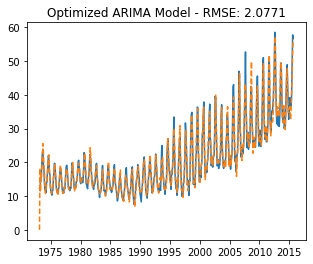

In [ ]:
# Optimized ARIMA
plt.figure(figsize=(5,4))
model_ARIMA2 =  ARIMA(GasEmissionsTrain, order=(12, 2, 4)) #Using p=12, d=2, q=4 and apply ARIMA function on df_shift series
results_ARIMA2 = model_ARIMA2.fit() #fit the model
plt.plot(GasEmissionsTrain,label='Data')
plt.plot(results_ARIMA2.fittedvalues,label='Fitted',linestyle='--')
plt.title('Optimized ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA2.fittedvalues,GasEmissionsTrain, squared=False))
plt.show()

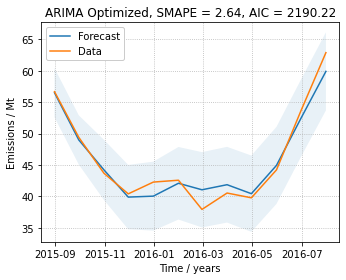

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

pred = results_ARIMA2.get_prediction(start = str(np.min(GasEmissionsTest.index)), end = str(np.max(GasEmissionsTest.index)), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

RMSE_Arima_Optim = mean_squared_error(pred.predicted_mean,GasEmissionsTest, squared=False)
SMAPE_Arima_Optim = CalculateSMAPE(pred.predicted_mean,GasEmissionsTest['Emissions'])
AIC_Arima_Optim = results_ARIMA2.aic

ax.plot(pred.predicted_mean,label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], alpha=.1)
ax.plot(GasEmissionsTest,label='Data')

ax.set_title('ARIMA Optimized, SMAPE = %.2f, AIC = %.2f'%(SMAPE_Arima_Optim, AIC_Arima_Optim))
ax.set_xlabel('Time / years')
ax.set_ylabel(r'Emissions / Mt')
ax.grid('on',linestyle=':')
ax.legend(framealpha=1)

fig.tight_layout()


**Observations & Insights:**
- The optimized model shows an drastic improve in performance, with SMAPE=2.64%.
- The AIC has drastically increased, since the model is much more complex (more coefficients) than the un-optimized ARIMA;
- The data is contained within the confidence interval of the forecast; 

## **Optimize the SARIMAX model**

In [ ]:
# Function to compute RMSE of SARIMAX
def RMSESarimax(p,d,q,P,D,Q,S,DataSetTrain,DataSetTest):
  model =  sm.tsa.statespace.SARIMAX(DataSetTrain, order=(p, d, q),seasonal_order=(P,D,Q,S),enforce_stationarity=False,enforce_invertibility=False)
  results = model.fit() #fit the model
  pred = results.get_prediction(start = str(np.min(DataSetTest.index)), end = str(np.max(DataSetTest.index)), dynamic=False)
  RMSETest = mean_squared_error(pred.predicted_mean,DataSetTest, squared=False)
  return RMSETest

In [ ]:
from tqdm import tqdm

Grid search algorithm to optimize SARIMAX model.

In [ ]:
# Grid search for arima (takes long to run)
'''
p_param = [0,1,2]
d_param = [0,1]
q_param = [0,1,2]
P_param = [0,1,2]
D_param = [0,1]
Q_param = [0,1,2]
S_param = [3,12]

rmse_tst = []
pp = []
dd = []
qq = []
PP = []
DD = []
QQ = []
SS = []

for i in tqdm(range(len(p_param))):
  for j in range(len(d_param)):
    for k in range(len(q_param)):
      for l in range(len(P_param)):
        for m in range(len(D_param)):
          for n in range(len(Q_param)):
            for o in range(len(S_param)):
              RMSE1 = RMSESarimax(p_param[i],d_param[j],q_param[k],P_param[l],D_param[m],Q_param[n],S_param[o],
                                        GasEmissionsTrain,GasEmissionsTest) # RMSE for test and train
              rmse_tst.append(RMSE1)
              pp.append(p_param[i])
              dd.append(d_param[j])
              qq.append(q_param[k])
              PP.append(P_param[l])
              DD.append(D_param[m])
              QQ.append(Q_param[n])
              SS.append(S_param[o])
'''

'\np_param = [0,1,2]\nd_param = [0,1]\nq_param = [0,1,2]\nP_param = [0,1,2]\nD_param = [0,1]\nQ_param = [0,1,2]\nS_param = [3,12]\n\nrmse_tst = []\npp = []\ndd = []\nqq = []\nPP = []\nDD = []\nQQ = []\nSS = []\n\nfor i in tqdm(range(len(p_param))):\n  for j in range(len(d_param)):\n    for k in range(len(q_param)):\n      for l in range(len(P_param)):\n        for m in range(len(D_param)):\n          for n in range(len(Q_param)):\n            for o in range(len(S_param)):\n              RMSE1 = RMSESarimax(p_param[i],d_param[j],q_param[k],P_param[l],D_param[m],Q_param[n],S_param[o],\n                                        GasEmissionsTrain,GasEmissionsTest) # RMSE for test and train\n              rmse_tst.append(RMSE1)\n              pp.append(p_param[i])\n              dd.append(d_param[j])\n              qq.append(q_param[k])\n              PP.append(P_param[l])\n              DD.append(D_param[m])\n              QQ.append(Q_param[n])\n              SS.append(S_param[o])\n'

In [ ]:
# Choose best model parameters as the lowest error on testing dataset (forecast)

#print(pp[np.argmin(rmse_tst)])
#print(dd[np.argmin(rmse_tst)])
#print(qq[np.argmin(rmse_tst)])
#print(PP[np.argmin(rmse_tst)])
#print(DD[np.argmin(rmse_tst)])
#print(QQ[np.argmin(rmse_tst)])
#print(SS[np.argmin(rmse_tst)])

The optimized parameters of the SARIMAX model are p=2, d=1, q=0, P=0, D=1, Q=1, S=12.

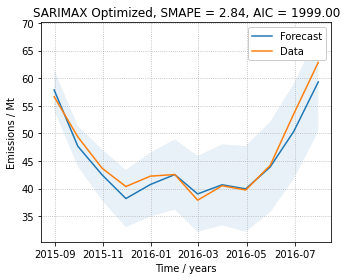

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

mod = sm.tsa.statespace.SARIMAX(GasEmissionsTrain,order=(2,1,0),seasonal_order=(0,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
results_SARIMAX = mod.fit()
pred = results_SARIMAX.get_prediction(start = str(np.min(GasEmissionsTest.index)), end = str(np.max(GasEmissionsTest.index)), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

RMSE_Sarimax_Optim = mean_squared_error(pred.predicted_mean,GasEmissionsTest, squared=False)
SMAPE_Sarimax_Optim = CalculateSMAPE(pred.predicted_mean,GasEmissionsTest['Emissions'])
AIC_Sarimax_Optim = results_SARIMAX.aic

ax.plot(pred.predicted_mean,label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], alpha=.1)
ax.plot(GasEmissionsTest,label='Data')

ax.set_title('SARIMAX Optimized, SMAPE = %.2f, AIC = %.2f'%(SMAPE_Sarimax_Optim, AIC_Sarimax_Optim))
ax.set_xlabel('Time / years')
ax.set_ylabel(r'Emissions / Mt')
ax.grid('on',linestyle=':')
ax.legend(framealpha=1)

fig.tight_layout()

**Observations and Insights:** 
- SARIMAX and ARIMA have similar performances but SARIMAX has lower AIC score than ARIMA (1952 < 2142) 
- I will choose SARIMAX for future forecasts because it has a lower complexity than ARIMA.

## **Auto-arima model to optimize SARIMAX**

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 33.1 MB/s 


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
auto_model_sarimax=auto_arima(GasEmissionsTrain,start_p=0,d=1,start_q=0,
          max_p=6,max_d=6,max_q=6, start_P=0,
          D=1, start_Q=0, max_P=6,max_D=6,
          max_Q=6, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2287.798, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2140.307, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2050.277, Time=0.49 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2242.342, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2052.108, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2052.093, Time=1.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2124.303, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=6.28 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2075.246, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2007.873, Time=0.94 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2009.871, Time=1.25 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2009.871, Time=2.46 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2094.406, Time=0.69 sec
 ARIMA(1,1,1)(1,1,2)[12]     

In [ ]:
auto_model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  512
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -999.937
Date:                            Wed, 19 Jan 2022   AIC                           2007.873
Time:                                    10:00:56   BIC                           2024.723
Sample:                                         0   HQIC                          2014.486
                                            - 512                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6658      0.036     18.549      0.000       0.595       0.736
ma.L1         -0.9637      0.016    -59.855      0.000      -0.995      -0.932
ma.S.L12      -0.7264      0.027    -26.960      0.000      -0.779      -0.674
sigma2         3.1488      0.126     24.931      0.000       2.901       3.396
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               220.04
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               8.41   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

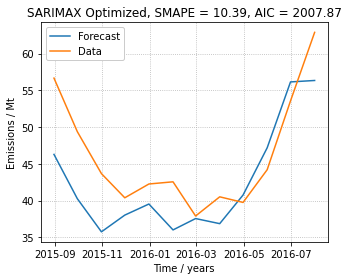

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

pred = pd.DataFrame(auto_model_sarimax.predict(n_periods=12), index=GasEmissionsTest.index)
pred.columns = ['Forecast']

RMSE_Sarimax_Optim = mean_squared_error(pred['Forecast'],GasEmissionsTest, squared=False)
SMAPE_Sarimax_Optim = CalculateSMAPE(pred['Forecast'],GasEmissionsTest['Emissions'])
AIC_Sarimax_Optim = auto_model_sarimax.aic()

ax.plot(pred,label='Forecast')
ax.plot(GasEmissionsTest,label='Data')

ax.set_title('SARIMAX Optimized, SMAPE = %.2f, AIC = %.2f'%(SMAPE_Sarimax_Optim, AIC_Sarimax_Optim))
ax.set_xlabel('Time / years')
ax.set_ylabel(r'Emissions / Mt')
ax.grid('on',linestyle=':')
ax.legend(framealpha=1)

fig.tight_layout()

**Observations and Insights:** 
- auto_arima optimizer yields a higher AIC (more complex) and SMAPE (worst performance) on the test dataset when compared to the manually programmed optimization;
- We will stick with the previously optimized SARIMAX;

## **Monte Carlo based Cross-Validation of SARIMAX**

In this section, I will use a Monte Carlo strategy for a cross-validation of the optimized SARIMAX model. Cross-validation of time series implies that the series has to be split by preserving the time order. The strategy I choose, is to split the series at a random time in the last 30 years of the data series. At the split time, the past is considered as the training data and the future (12 months ahead) as the testing data. At each run, a random split is assigned, the model trained and forecast performance compared with observations. The performance is evaluated in terms of SMAPE between forecasts and data at different times of the forecast. All data is aggregated and statistics are computed for each month ahead of the forecast

Define useful functions

In [ ]:
def SplitTrainTestRandom(Dataset):
  # Build the bounding indices
  InfIndex = Dataset.shape[0]-12*30 
  SupIndex = Dataset.shape[0]-13
  IndexT0 = np.random.randint(InfIndex,SupIndex) #indices split 30 to 1 years back
  IndexT1 = IndexT0 + 13

  # Split dataset
  TrainDS = Dataset.iloc[:IndexT0] 
  TestDS = Dataset.iloc[IndexT0:IndexT1] 

  return TrainDS, TestDS

def TrainAndForecast(method):
  # Split data into testing and training
  Tr_, Te_ = SplitTrainTestRandom(GasEmissions)
  
  # Choose and train the model
  if method=='ARIMA':
    Model_ =  ARIMA(Tr_, order=(12, 2, 4)) 
  elif method=='SARIMAX':
    Model_ = sm.tsa.statespace.SARIMAX(Tr_,order=(2,1,0),seasonal_order=(0,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
  else:
    print('Wrong method selection, choose between ARIMA and SARIMAX')
  Results_ = Model_.fit()
  
  # Make predictions in the testing data
  Pred_ = Results_.get_prediction(start = str(np.min(Te_.index)), end = str(np.max(Te_.index)), dynamic=False) 

  # Calculate SMAPE with time of the forecast
  SMAPE_time = []
  for i in range(1,len(Pred_.predicted_mean)):
    SMAPE_time.append(CalculateSMAPE(Pred_.predicted_mean[:i],Te_.Emissions[:i]))
  
  # Calculate global SMAPE
  SMAPE_ = CalculateSMAPE(Pred_.predicted_mean,Te_['Emissions'])

  return SMAPE_, SMAPE_time

Assess the timing performance of each method in terms of train and forecast assessment before entering a Monte Carlo loop

In [ ]:
%timeit TrainAndForecast('ARIMA')

1 loop, best of 5: 1.81 s per loop


In [ ]:
%timeit TrainAndForecast('SARIMAX')

1 loop, best of 5: 204 ms per loop


**Obeservations and Insights:**
- The SARIMAX evaluation is much more rapid than ARIMA (approximately 10 times).
- Higher evaluation speed is connected to a lower complexity of SARIMAX, which reinforces the choice of SARIMAX for future forecasts.

Run Monte Carlo simulations

In [ ]:
def RunMC_Validations(n_simulations, method):
  # Build matrix of residuals, 1 line per simulations, 1 column per month of forecast
  smape_validate = []
  Matrix = np.zeros([n_simulations,12])

  # Iterate over simulations
  for i in tqdm(range(n_simulations)):
    # Train and forecast SARIMAX
    AA_ = TrainAndForecast(method)

    # Assign residual of single simulation to the matrix row
    Matrix[i,:] = np.asarray(AA_[1]).transpose()

    # Assign SMAPE and MAPE
    smape_validate.append(AA_[0])

  return Matrix, smape_validate

Build matrix of residuals of all simulations. Compute the mean and standard deviation of all simulations at each month ahead of the forecast.

In [ ]:
def cycle_over(n_sim=100):
  # Run whole set
  Matrix, smape_validate = RunMC_Validations(n_sim,'SARIMAX') # takes long to run

  # Save Matrix to file
  pd.DataFrame(Matrix).to_csv('/content/drive/MyDrive/DataScienceMIT/Capstone/MC_Results_nsim'+str(n_sim)+'.csv',index=False)
  pd.DataFrame(smape_validate).to_csv('/content/drive/MyDrive/DataScienceMIT/Capstone/MC_SMAPE_Results_nsim'+str(n_sim)+'.csv',index=False)

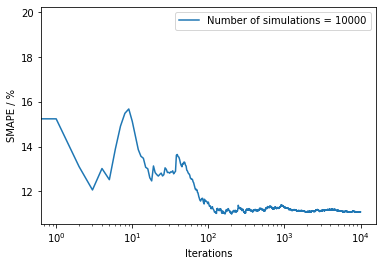

In [ ]:
# Validate the time-evolution of SMAPE to make sure we are doing enough MC cycles
n_sim = 10000

#cycle_over(n_sim) # takes long time to run

# Load saved csv files
Matrix = np.asarray(pd.read_csv('/content/drive/MyDrive/DataScienceMIT/Capstone/MC_Results_nsim'+str(n_sim)+'.csv',index_col=False))
smape_validate = np.asarray(pd.read_csv('/content/drive/MyDrive/DataScienceMIT/Capstone/MC_SMAPE_Results_nsim'+str(n_sim)+'.csv',index_col=False))

# Calculate and plot mean over time
mean_in_time = []
for i in range(1,len(smape_validate)):
  mean_in_time.append(np.mean(smape_validate[:i]))
plt.semilogx(mean_in_time,label='Number of simulations = '+str(n_sim))
plt.xlabel('Iterations')
plt.ylabel(r'SMAPE / %')
plt.legend()

**Observations:**
- $10^4$ simulations are enough as the average SMAPE at iteration n is stabilizing after $10^3$ cycles.

In [ ]:
# Calculate mean and std for each month of forecast ahead
mean_ = []
std_ = []
for i in range(12):
  mean_.append(Matrix[:,i].mean())
  std_.append(Matrix[:,i].std())

Plot the residuals ahead of each month of the forecast

No handles with labels found to put in legend.


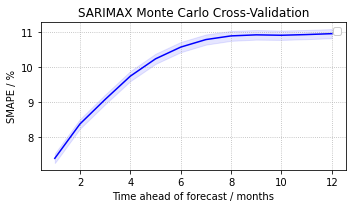

In [ ]:
# Import z score for CI
import scipy.stats as st
p95 = st.norm.ppf(0.99)

# Assign mean and std as numpy vectors
mean_ = np.asarray(mean_)
std_ = np.asarray(std_)
# Calculate confidence intervals with p=95%
ci_up = mean_ + std_ * p95 / np.sqrt(n_sim)
ci_lo = mean_ - std_ * p95 / np.sqrt(n_sim)
months = np.arange(len(ci_lo)) + 1

# Plot mean and confidence intervals
fig, ax = plt.subplots(1,1, figsize=(5,3))

ax.plot(months,mean_,'b')
ax.fill_between(months,ci_lo,ci_up, color='b', alpha=.1)

ax.set_title('SARIMAX Monte Carlo Cross-Validation')
ax.set_xlabel('Time ahead of forecast / months')
ax.set_ylabel(r'SMAPE / %')
ax.grid('on',linestyle=':')
ax.legend(framealpha=1)
#ax.set_xlim([0,12])
fig.tight_layout()

**Observations:**
- Forecast are worsening in the first 8 months after time t0 and then stabilize at SMAPE$\approx11$%;
- Uncertainty slightly increases with time ahead of the forecast as shown by a growing confidence interval;
- SMAPE falls between 7% to 11% roughly;

Plot the SMAPE boxplot and  distribution of all simulations

No handles with labels found to put in legend.


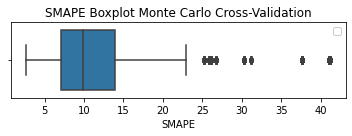

In [ ]:
import seaborn as sns

# Boxplot of MAPE distribution
# Plot mean and confidence intervals
fig, ax = plt.subplots(1,1, figsize=(5,2))

sns.boxplot(x=smape_validate,ax=ax)

ax.set_title('SMAPE Boxplot Monte Carlo Cross-Validation')
ax.set_xlabel('SMAPE')
ax.legend(framealpha=1)
fig.tight_layout()

In [ ]:
# Calculate outliers with SMAPE > 25%
print('High SMAPE outliers percentage:')
smape_validate[smape_validate>25].shape[0]/len(smape_validate)*100

High SMAPE outliers percentage:


2.46

**Observations**:
- The median SMAPE is around 10%;
- Most simulations fall within 15% of MAPE;
- Outliers of very high SMAPE ($>25\,\%$) are present with a low likelyhood of $\approx 2.46\,\%$;

## **Forecasting**

In [ ]:
from dateutil.relativedelta import relativedelta

Forecasting 1 year ahead of the current maximum time

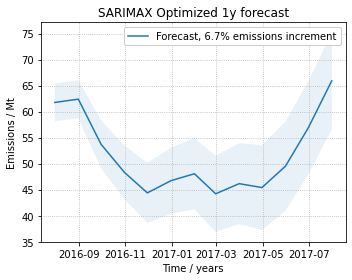

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

years_ahead = 1
mod = sm.tsa.statespace.SARIMAX(GasEmissions,order=(2,1,0),seasonal_order=(0,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
results_SARIMAX = mod.fit()
pred = results_SARIMAX.get_prediction(start = str(np.max(GasEmissions.index)), end = str(np.max(GasEmissions.index) + relativedelta(years=years_ahead)), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

ForecastedPercentageIncrease = (pred.predicted_mean[-1] - pred.predicted_mean[0])/pred.predicted_mean[0]
PercIncrementCO2 = "{:.1%}".format(ForecastedPercentageIncrease)

ax.plot(pred.predicted_mean,label=r'Forecast, '+PercIncrementCO2+' emissions increment')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], alpha=.1)

ax.set_title('SARIMAX Optimized 1y forecast')
ax.set_xlabel('Time / years')
ax.set_ylabel(r'Emissions / Mt')
ax.grid('on',linestyle=':')
ax.legend(framealpha=1)

fig.tight_layout()

Visualizing the last 10 years to compare percentage increment

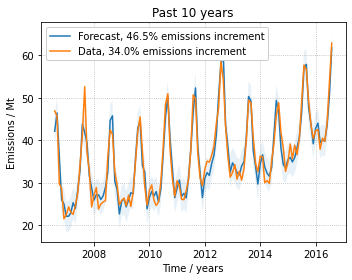

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

start_date = '2006-07-31'
end_date = '2016-07-31'
GasEmissionsLast10y = GasEmissions[start_date:end_date]
years_ahead = 1
mod = sm.tsa.statespace.SARIMAX(GasEmissions,order=(2,1,0),seasonal_order=(0,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
results_SARIMAX = mod.fit()
pred = results_SARIMAX.get_prediction(start = start_date, end = end_date, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

ForecastedPercentageIncrease = (pred.predicted_mean[-1] - pred.predicted_mean[0])/pred.predicted_mean[0]
PercIncrementCO2 = "{:.1%}".format(ForecastedPercentageIncrease)

DataPercentageIncrease = (GasEmissionsLast10y.Emissions[-1] - GasEmissionsLast10y.Emissions[0])/GasEmissionsLast10y.Emissions[0]
PercIncrementCO2Data = "{:.1%}".format(DataPercentageIncrease)

ax.plot(pred.predicted_mean,label=r'Forecast, '+PercIncrementCO2+' emissions increment')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], alpha=.1)
ax.plot(GasEmissionsLast10y,label=r'Data, '+PercIncrementCO2Data+' emissions increment')

ax.set_title('Past 10 years')
ax.set_xlabel('Time / years')
ax.set_ylabel(r'Emissions / Mt')
ax.grid('on',linestyle=':')
ax.legend(framealpha=1)

fig.tight_layout()

**Observations and insights:**

- The forecasted increment is approximately 7% for 2017;
- In the past 10 years, an average of 3.4% increment per year has been observed;

## **Final observations**

**Observations and insights:**

- The original time series of natural gas CO$_2$ emissions is non-stationary;
- Log and shift-1 transformations make the series stationary;
- ACF and PACF plots are not very useful in choosing optimized parametes;
- AR, MA, ARMA and ARIMA series with parameters chosen from PACF and applied to log-shifted time series provided unreliable forecasts;
- Optimizing ARIMA with a grid search yielded very good predictions (MAPE$<$3%);
- Optimizing SARIMAX with a grid search yielded a performance in-line with ARIMA;
- The optimzed SARIMAX has a lower AIC score than ARIMA and is trained and evaluated 4 times faster;
- Because SARIMAX has a similar performance than ARIMA (difference in MAPE is $<$8%), but a lower complexity, I have chosen the optimized SARIMAX as the final tool to forecasts;
- A Monte Carlo cross-validation of the SARIMAX model was used to build uncertainty in the forecasts;
- The Monte Carlo analysis showed that forecast reliability decreases with time ahead of the forecast with a peak at 6 months;
- Globally, the forecast is highly reliable with a mean SMAPE at 10%;
- The forecast shows an increment of CO$_2$ emissions from natural gas from 2016 to 2017 of 6.7%;
- The situation is not only worsening (more emissions), but the models indicates for 2017 a situation worsening and an increased pace (6.7% vs the 3.4% average annual increment in the past 10 years);